# Train Neural Model for extracting company names </br>
- This notebook builds company name extractor using Keras library, pretrained BERT embeddings (huggingface library) and spatial context (in multiple directions)


Final Intern presentation: https://docs.google.com/presentation/d/10mXA7K5sa_nAkqx2onsIfrH3TPj2Ni4LfCOxDhN5XBI/edit?usp=sharing

In [1]:
import os
import importlib
import logging
importlib.reload(logging)
import framework
importlib.reload(framework)
import MultiLayerPerceptron
importlib.reload(MultiLayerPerceptron)
import infer_bert_classifier
importlib.reload(infer_bert_classifier)
import bert_utils
importlib.reload(bert_utils)
import pandas as pd
import time
import keras
from framework import DataCuration, Task
from MultiLayerPerceptron import FeatureEngineeringMultiLayerPerceptron, MultiLayerPerceptron
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Define some constants and configurations
logging.getLogger().setLevel(logging.INFO)
ACCESS_TOKEN = 'WUpGevbWC9lsnTW8quNUtmWRdAEM89'

Using TensorFlow backend.


## Specify Task
- Mention configurations of the task and create a task object

In [2]:
DATASET = 'omf-paystubs' # supports w2 and resume
TASK_CONFIG = {
    'task': 'cmp_name',
}

task = Task(TASK_CONFIG)

## Curate dataset
- Specify paths for dataset and goldens (if available). Paths can be local or from instabase drives (use *is_local*). 
- Also specify configurations like extensions, column names to use as index. 
- Currently supports csv format for goldens, ibocr/ibdoc for dataset. 
- Use *context2txt* to extract and store raw texts. 
- This block creates a object of DataCuration() which maps goldens with the dataset and removes any mismatches, generates 1:1 mapping. 
- This object can be queried using *data.golden* or *data.dataset* or *data.dataset.texts* based on requirement

### Files:
- Download documents (ibocr or ibdoc files) and specify local directory path (set *is_local* = True)
- Alternatively, specify instabase drive paths (as below) and set *is_local* as False
- Goldens for OMF dataset can be found here: https://drive.google.com/drive/folders/18U8io_x1T-CfgctNBW2gziL2WGUnHMOl?usp=sharing


In [3]:
OMF_DATA = [
    'ib_sales/OMF/fs/Instabase%20Drive/test/other-paystubs/Batch1/out/s3_map_records/',
    # 'ib_sales/OMF/fs/Instabase%20Drive/test/other-paystubs/Batch2/out/s3_map_records/',
    # 'ib_sales/OMF/fs/Instabase%20Drive/test/other-paystubs/Batch3/out/s1_process_files/',
    # 'ib_sales/OMF/fs/Instabase%20Drive/test/other-paystubs/Batch4/out/s1_process_files/'
]
OMF_GOLDEN = [
    './omf_batch_1.csv',
    # './omf_batch_2.csv',
    # './omf_batch_3.csv',
    # './omf_batch_4.csv'
]

GOLDEN_CONFIG = {
    'path': OMF_GOLDEN,
    'is_local': True,
    'index_field_name':'filename',
    'file_type': 'csv',
    'identifier': 'file'
}
DATASET_CONFIG = {
    'path': OMF_DATA,
    'is_local': False, 
    'file_type': 'ibdoc',
    'identifier': lambda path: os.path.basename(path).split('.ibdoc')[0],
    'convert2txt': False
}


data = DataCuration(ACCESS_TOKEN, DATASET_CONFIG, GOLDEN_CONFIG)

INFO:root:Loading dataset from ib_sales/OMF/fs/Instabase%20Drive/test/other-paystubs/Batch1/out/s3_map_records/
INFO:root:101 files loaded
INFO:root:Loading goldens from ./omf_batch_1.csv
INFO:root:Goldens have non-unique filenames, keeping only the first values
INFO:root:Total files Goldens: (117, 17)
INFO:root:Total files found in the source with unique index: (101, 17)


## Feature Engineering (Generate Labeled Data)
- Specify DATA_ARGS which includes the task and data objects created beforehand
- Mention fields of interest (for extraction, classification) in DATA_ARGS
- Specify preprocessing arguments in *data_config* of DATA_ARGS
- Split data in train, test

In [4]:
# ToDo: add ModelSelection() hyperparameter search in the framework

DATA_ARGS = {
    'task': task,
    'dataset': data,
     'candidates_fields': {
        'person':'employee_name',
        'org':'employer_name'
    },
    'data_config': {
        'max_num_tokens': 5,
        'max_token_distance': None,
        'embedding_type': 'bert',
        'cardinal_only': False,
        'balance_targets': True,
        'additional_features': [],
        'pre_processing': ['lower_case', 'remove_punc']
    }
}


fe = FeatureEngineeringMultiLayerPerceptron(DATA_ARGS)
samples = fe.create_train_test_data()
print('Input shape: {}'.format(samples[0].shape))


INFO:root:Building BERT Model embeddings using pretrained model
INFO:root:Finished Loading Model, computing embeddings
Input shape: (578, 31488)


## Modeling (Keras Neural Network)
- Specify model type (architecture) with number of layers, neurons, activation functions
- This model uses multi-layer Perceptron (Neural Network) to train the classifier

### Specify TRAINING_ARGS
- Specify training hyperparameters like epochs, batch_size

### This block performs the following
- Trains model and saves the model output (for future inference)
- Generare plots (during training)
- Evaluate models performance on test data, prints classification accuracy and loss values

In [5]:
TRAINING_ARGS = {
    'batch_size': 32,
    'epochs': 25, 
}

# Neural network
model_architecture = Sequential()
model_architecture.add(Dense(512, input_dim=samples[0].shape[1], activation='relu'))
model_architecture.add(Dropout(0.5))
model_architecture.add(Dense(128, activation='relu'))
model_architecture.add(Dropout(0.5))
model_architecture.add(Dense(1, activation='sigmoid'))
model_architecture.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model = MultiLayerPerceptron(DATA_ARGS, TRAINING_ARGS, model_architecture)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Colocations handled automatically by placer.


INFO:root:Training multilayer perceptron model for 578 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Train on 578 samples, validate on 248 samples
Epoch 1/25
578/578 [==============================] - 4s 6ms/step - loss: 2.6551 - accuracy: 0.5571 - val_loss: 0.8956 - val_accuracy: 0.7258
Epoch 2/25
578/578 [==============================] - 3s 5ms/step - loss: 1.4161 - accuracy: 0.6782 - val_loss: 0.5908 - val_accuracy: 0.7742
Epoch 3/25
578/578 [==============================] - 3s 5ms/step - loss: 1.0198 - accuracy: 0.7318 - val_loss: 0.5599 - val_accuracy: 0.7056
Epoch 4/25
578/578 [==============================] - 3s 5ms/step - loss: 0.7845 - accuracy: 0.7474 - val_loss: 0.4344 - val_accuracy: 0.8065
Epoch 5/25
578/578 [==============================] - 3s 5ms/step - loss: 0.6561 - accuracy: 0.7595 - val_loss: 0.4256 - val_accuracy: 0.8226
Epoch 6/25
578/578 [==============================] - 3s 5ms/step - loss: 0.5397 - ac

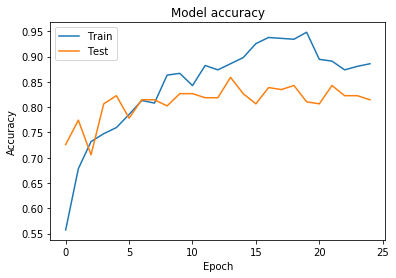

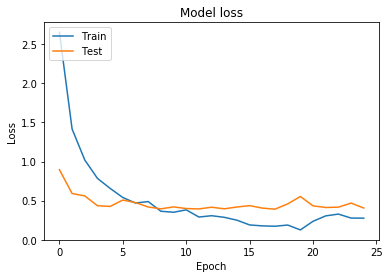

INFO:root:Accuracy is 0.8145161271095276


In [6]:
model.train(*samples)
acc = model.evaluate()
logging.info("Accuracy is {}".format(acc))

## Predictions
- Setup model evaluator and get predictions for all/selected samples
- Print extractions (company names)

In [7]:
found_companies = model.predict(num_samples=1)
print(found_companies)

INFO:root:Running predictions for file: APPELF__0089-000000009025750-00892881_&I100PYSTB_20191017005144_01000059-09025750-00892881-001_19_.pdf
INFO:root:Getting features to predict
INFO:root:Inferring trained model for prediction
INFO:root:Printing predictions, concatenating outputs
{'APPELF__0089-000000009025750-00892881_&I100PYSTB_20191017005144_01000059-09025750-00892881-001_19_.pdf': ['Warrior Met Coal Mining, LLC', '216 Brookwood,', 'Ricky L. Tucker', 'Warrior Met Coal Mining,', 'Fargo Bank', 'Wells Fargo', 'Fargo Bank', 'Wells Fargo']}


## Evaluation
- Use *model.analyze_result()* to compares predictions with goldens.
- Also calculates metrics like Recall

In [8]:
model.analyze_result(found_companies)

01_19_.pdf
	 Found:
		Warrior Met Coal Mining, LLC
		216 Brookwood,
		Ricky L. Tucker
		Warrior Met Coal Mining,
		Fargo Bank
		Wells Fargo
		Fargo Bank
		Wells Fargo
	 Expected:
		Warrior Met Coal Mining, LLC
1
1
Recall: 1.0


In [9]:
# model.demo()